Assignment 4: Multi-Output Networks and Batch Processing
========================================================


Microsoft Forms Document: https://forms.office.com/r/nHKeCdSmTz


Task 1: Dataset Loading
-----------------------

Load the dataset from files and provide the input matrix $\mathbf X \in \mathbb R^{(D+1)\times N}$ and the output matrix $\mathbf T \in \mathbb R^{O\times N}$.
For more information about the dataset, refer to https://archive.ics.uci.edu/ml/datasets/Student+Performance.

We skip categorical inputs (indexes 8-11) for now.
All other entries are converted either into binary $(-1,1)$ or into an integer range $(0,1,\ldots)$.
The three outputs range between 0 and 20 each.

In [1]:
import math
import os

import numpy as np

# Dataset origin: https://archive.ics.uci.edu/ml/datasets/Student+Performance


def dataset(course="mat"):
    # load dataset and provide input and target data
    # possible data files are "mat" and "por"

    # download data file from URL
    dataset_zip_file = "student.zip"
    if not os.path.exists(dataset_zip_file):
        import urllib.request

        urllib.request.urlretrieve(
            "https://archive.ics.uci.edu/ml/machine-learning-databases/00320/student.zip",
            dataset_zip_file,
        )
        print("Downloaded datafile", dataset_zip_file)

    import csv
    import io
    import zipfile

    # collect inputs
    inputs = []
    targets = []
    # some default values: yes=1, no=-1
    # 用字典的方式 转化成 0 和 1
    yn = {"yes": 1.0, "no": -1.0}
    # read through dataset (without actually unzippiung to a file):
    # ... open zip file
    zip = zipfile.ZipFile(dataset_zip_file)
    # ... open data file inside of zip file and convert bytes to text
    datafile = io.TextIOWrapper(zip.open(os.path.join(f"student-{course}.csv"), "r"))
    # ... read through the lines via CSV reader, using the correct delimited
    reader = csv.reader(datafile, delimiter=";")
    # ... skip header line
    next(reader)
    for splits in reader:
        # read input values
        inputs.append(
            [
                1.0,  #### BIAS ####
                {"GP": 1.0, "MS": -1.0}[splits[0]],  # school
                {"M": 1.0, "F": -1.0}[splits[1]],  # gender
                float(splits[2]),  # age
                {"U": 1.0, "R": -1.0}[splits[3]],  # address
                {"LE3": 1.0, "GT3": -1.0}[splits[4]],  # family size
                {"T": 1.0, "A": -1.0}[splits[5]],  # parents living together
                float(splits[6]),  # mother education
                float(splits[7]),  # father education
                # skip categorical values
                float(splits[12]),  # travel time
                float(splits[13]),  # study time
                float(splits[14]),  # failures
                yn[splits[15]],  # extra support
                yn[splits[16]],  # family support
                yn[splits[17]],  # paid support
                yn[splits[18]],  # activities
                yn[splits[19]],  # nursery school
                yn[splits[20]],  # higher education
                yn[splits[21]],  # internet
                yn[splits[22]],  # romantic
                float(splits[23]),  # family relation
                float(splits[24]),  # free time
                float(splits[25]),  # going out
                float(splits[26]),  # workday alcohol
                float(splits[27]),  # weekend alcohol
                float(splits[28]),  # health
                float(splits[29]),  # absences
            ]
        )

        # read targets values
        targets.append(
            [
                float(splits[30]),  # grade for primary school
                float(splits[31]),  # grade for secondary school
                float(splits[32]),  # grade for tertiary school
            ]
        )

    print(f"Loaded dataset with {len(targets)} samples")
    # 因为这里的 inputs 和 targets 是 list， 所以不能直接 .T
    # 我们可以用 np.transpose(list)。 最后会返回一个 np.array 的 type
    return np.transpose(inputs), np.transpose(targets)

Test 1: Assert Valid Outputs
----------------------------

Load the dataset and check that all target data are in range 0-20. Also make sure that the dataset is in the correct dimensions, i.e., $\mathbf X\in \mathbb R^{(D+1)\times N}$ and $\mathbf T \in \mathbb R^{O\times N}$.

In [2]:
# load dataset
X, T = dataset()

# check validity
print("X shape:", X.shape)
print("T shape:", T.shape)

### 熟练运用 np.all() 可以直接在括号里写 np.array
assert (T >= 0).all() and (T <= 20).all()

Loaded dataset with 395 samples
X shape: (27, 395)
T shape: (3, 395)


Task 2: Input Data Normalization
--------------------------------

Implement a function that normalizes all input data using the whitening method with given mean and standard deviation.
Compute the mean and the standard deviation for your dataset.
Make sure that you handle the bias neuron $x_0$ correctly.
Finally, normalize your input data using the implemented function.

In [3]:
# compute mean and standard deviation over dataset
mean = np.mean(
    X, axis=1
)  # axis=1 ===> 怎么记？ 原本的shape(D+1)xN ===> 消除掉 shape[1] ===> np.mean 之后的shape (D+1),
print(mean.shape)
std = np.std(X, axis=1)
print(std.shape)

# assure to handle x_0 correctly ?????????????????????? 为啥？？？？？？
mean[0] = 0
std[0] = 1

### 对于 矩阵 和 vector 的 基本运算，注意 broadcast。
### matrix.T.shape = (N,D)   <===> vector.shape = (D,)
### OR ==> matrix.shape = (D,N) <===> np.expand_dims(vector,axis=1).shape = (D,1)
### 增加 axis=1 的 dims 也可以是 np.array([vector]).T
def normalize(X, mean, std):
    return (X - np.expand_dims(mean, axis=1)) / np.expand_dims(std, axis=1)
    # return ((x.T - mean) / std).T


# # normalize our dataset
X = normalize(X, mean, std)

(27,)
(27,)


Task 3: Batch Processing
------------------------

Implement a function that turns the dataset $(X,T)$ into batches of a certain batch size $B$.
Implement this function as a generator function, i.e., use ``yield`` instead of ``return``.
Make sure that you yield both the input batch as well as the target batch.


In [4]:
def batch(X, T, batch_size=16):
    # shuffle = np.random.permutation() // 里面可以填 int 或者 np.array
    # https://numpy.org/doc/stable/reference/random/generated/numpy.random.permutation.html
    N = T.shape[1]
    shuffle = np.random.permutation(N)  ### store the total shuffled indices
    SEEN_NUM = 0

    while True:
        # shuffle dataset in each epoch
        yield X[:, shuffle[SEEN_NUM : SEEN_NUM + batch_size]], T[
            :, shuffle[SEEN_NUM : SEEN_NUM + batch_size]
        ]
        SEEN_NUM += batch_size
        if SEEN_NUM >= N:
            shuffle = np.random.permutation(N)
            SEEN_NUM = 0

Test 2: Test your Batches
-------------------------

Make sure that your batch function returns batches in the correct size and with the correct content, i.e., $(\vec x, \vec t)$-alignment.
Select appropriate test data that makes it easy to test this.

Also check that the batches are in the correct dimensions, i.e., that $\mathbf X \in \mathbb R^{(D+1)\times B}$ and $\mathbf T \in \mathbb R^{O\times B}$

In [5]:
# designe and create test data to test your batch processing function
XX = np.arange(0, 30).reshape(3, 10)  ##  D = 3; N = 10
TT = XX[:2] * 2  ##  O = 2; N = 10


for counter, (x, t) in enumerate(batch(XX, TT, 16)):
    # test that the batches are in the desired form and content
    print("x: \n", x, "\n x shape: ", x.shape)
    print("t: \n", t, "\n t shape: ", t.shape)
    assert np.all(t == x[:2] * 2)
    # we run this for a couple of batches, to assure that it works over some epochs
    if counter == 20:
        break

x: 
 [[ 8  7  6  5  4  2  1  9  0  3]
 [18 17 16 15 14 12 11 19 10 13]
 [28 27 26 25 24 22 21 29 20 23]] 
 x shape:  (3, 10)
t: 
 [[16 14 12 10  8  4  2 18  0  6]
 [36 34 32 30 28 24 22 38 20 26]] 
 t shape:  (2, 10)
x: 
 [[ 3  4  8  5  2  9  7  6  0  1]
 [13 14 18 15 12 19 17 16 10 11]
 [23 24 28 25 22 29 27 26 20 21]] 
 x shape:  (3, 10)
t: 
 [[ 6  8 16 10  4 18 14 12  0  2]
 [26 28 36 30 24 38 34 32 20 22]] 
 t shape:  (2, 10)
x: 
 [[ 8  0  7  2  5  3  1  4  6  9]
 [18 10 17 12 15 13 11 14 16 19]
 [28 20 27 22 25 23 21 24 26 29]] 
 x shape:  (3, 10)
t: 
 [[16  0 14  4 10  6  2  8 12 18]
 [36 20 34 24 30 26 22 28 32 38]] 
 t shape:  (2, 10)
x: 
 [[ 4  0  1  7  6  8  2  9  3  5]
 [14 10 11 17 16 18 12 19 13 15]
 [24 20 21 27 26 28 22 29 23 25]] 
 x shape:  (3, 10)
t: 
 [[ 8  0  2 14 12 16  4 18  6 10]
 [28 20 22 34 32 36 24 38 26 30]] 
 t shape:  (2, 10)
x: 
 [[ 2  0  6  4  7  1  5  3  8  9]
 [12 10 16 14 17 11 15 13 18 19]
 [22 20 26 24 27 21 25 23 28 29]] 
 x shape:  (3, 10)
t: 
 [[

Task 4: Multi-Output Network
----------------------------

Implement a multi-target network that computes the output matrix $\mathbf Y$ for a given input dataset/batch $\mathbf X$ and given parameters $\Theta=(\mathbf W^{(1)}, \mathbf W^{(2)})$. 
The function should return both the output of the hidden units $\mathbf H$ as well as the network output $\mathbf Y$. Select $\tanh$ as the activation function.

In [6]:
def network(X, Theta):
    W1, W2 = Theta

    # compute activation
    # 在维度都是2维的时候，np.matmul() 和 np.dot() 是相同的
    A = np.dot(W1, X)  # ((K+1),(D+1)) (D+1,B) ==> ((K+1),B)

    # compute hidden unit output
    H = np.tanh(A)  # ((K+1),B)

    # reset the bias of H
    # 直接写 H[0] = 1 也可以
    # H[0] = np.ones(H.shape[1])
    H[0] = 1

    # compute network output
    Y = np.dot(W2, H)  # (O,(K+1))  ((K+1),B) ==> (O,B)

    return Y, H

Task 5: Loss Implementation
---------------------------

Implement a function that computes the loss $\mathcal J^{L_2}_\Theta$ for a given network output $\mathbf Y$, and their according targets $\mathbf T$.

In [7]:
def loss(Y, T):
    N = Y.shape[1]
    # https://numpy.org/doc/stable/reference/generated/numpy.linalg.norm.html
    # 对于矩阵来说 Fro 范数是默认的 （各元素相减后的平方）
    return (np.linalg.norm(Y - T, ord="fro") ** 2) / N

Task 6: Gradient Implementation
-------------------------------

Implement a function that computes the gradient $\nabla_\Theta\mathcal J^{L_2}$ for both weight matrices $\Theta=(\mathbf W^{(1)}, \mathbf W^{(2)})$.
Assume that the function gets the network input, $\mathbf X$, its output $\mathbf Y$, hidden unit activations $\mathbf H$ and target values $\mathbf T$.
Remember that we have used $\tanh$ as the activation function and change the implementation seen in the lecture accordingly.


In [8]:
def gradient(X, T, Y, H, Theta):
    W1, W2 = Theta
    N = T.shape[1]
    
    ### First layer 和 Second layer 顺序别搞错了！！！ First layer 要复杂一些
    
    # first layer gradient
    g1 = (2 / N) * np.dot(np.dot(W2.T, (Y - T)) * (1 - H * H), X.T)
    # second layer gradient
    g2 = (2 / N) * np.dot((Y - T), H.T)

    return g1, g2

Task 7: Iterative Gradient Descent
----------------------------------
Implement the iterative gradient descent using the normalized dataset from Task 2, split into batches with the function from Task 3, the network from Task 4, the loss from Task 5 and the gradient from Task 6.
Make sure that the network output $\mathbf Y$ and the hidden unit output $\mathbf H$ is computed only once for each batch.
Store the loss values for each batch in a list and return it at the end.
Use the number of epochs to be 10000, the batch size $B$, and the learning rate $\eta=0.001$.
How many iterations do we need when $B<N$?

In [9]:
def gradient_descent(X, T, Theta, B, eta=0.001):
    loss_values = []

    max_epochs = 10000
    max_batches = (T.shape[1] // B) * max_epochs
    batches = 0

    # iterate over batches
    for x, t in batch(X, T, B):
        # compute network output
        y, h = network(x, Theta)
        
        # compute and append loss
        l = loss(y, t)

        # compute gradient
        g1, g2 = gradient(x, t, y, h, Theta)
        
        # and apply gradient descent
        Theta[0] -= eta * g1
        Theta[1] -= eta * g2
        
        if not batches % (T.shape[1] // B):
            loss_values.append(l)
        
        batches += 1
        if batches > max_batches:
            break
        
    # return the obtained loss values at the end
    return loss_values

Task 8: Run Gradient Descent
----------------------------

Select an appropriate number of hidden neurons $K$.
Instantiate the weight matrices using the Xavier method as introduced in the lecture.
Run the gradient descent twice, once as stochastic gradient descent with batch size $B=16$ and once as normal gradient descent.
How can you achieve this without providing a different implementation for the ``gradient_descent`` function?


In [10]:
K = 20
D = X.shape[0]
O = T.shape[0]

### Xavier
s = 1 / np.sqrt(D)
W1 = np.random.uniform( -s, s, size =(K+1,D) )
W2 =  np.random.uniform( -s, s, size =(O,K+1) )
Theta = [W1, W2]

import copy

# run gradient descent with full dataset
Theta1 = copy.deepcopy(Theta)
N = T.shape[1]
GD = gradient_descent(X, T, Theta1, N, eta=0.001)

# run stochastic gradient descent with batches of size 16
Theta2 = copy.deepcopy(Theta)
SGD = gradient_descent(X, T, Theta2, B=16, eta=0.001)

Task 9: Plotting Loss Progression
---------------------------------

Plot the progression of the two gradient descent steps together into one plot.
Do we need to take care of something when plotting both together?
Choose logarithmic axes whenever you see fit.

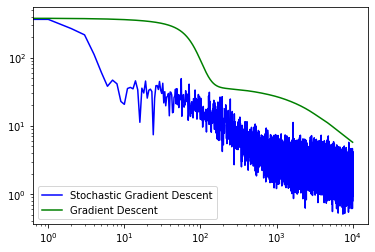

In [11]:
from matplotlib import pyplot

pyplot.plot(SGD, "b-", label="Stochastic Gradient Descent")
pyplot.plot(GD, "g-", label="Gradient Descent")
pyplot.loglog()
pyplot.legend()
pyplot.show()

Task 10: Example Evaluation
---------------------------

We want to see what the network has learned.
Therefore, we evaluate some data point that would represent a typical Swiss student (except for the school entry, where we select one of them randomly).
We select appropriate information for all inputs, see https://archive.ics.uci.edu/ml/datasets/Student+Performance for an explanation of typical values.

Also remember that input data need to be normalized before feeding it to the network.

In [12]:
# select a specific example
example = np.array(
    [
        [
            1.0,  # BIAS
            -1,  # school (select -1 or 1)
            1,  # gender
            18,  # age
            1,  # adress
            1,  # family size
            1,  # parents living together
            1,  # mother education
            1,  # father education
            1,  # travel time
            4,  # study time
            0,  # class failure before
            1,  # support from school
            1,  # support from the family
            1,  # paid extra support
            -1,  # out-of-school activities
            1,  # nursery school
            1,  # want to do higher ed
            1,  # internet access
            1,  # romantic relation
            1,  # relation to family
            3,  # amount of free time
            1,  # go out with peers
            6,  # alcoholic drinks during week
            1,  # alcoholic drinks in the weekend
            1,  # health status
            0,  # days of absence
        ]
    ]
).T

###### 在预测之前，也必须normalize！！！
example = normalize(example, mean, std)
print(example)
# compute network output
prediction = network(example, Theta2)[0]
print("Prediction :\t", prediction)

[[ 1.        ]
 [-2.75444305]
 [ 1.05465609]
 [ 1.02304645]
 [ 0.53539233]
 [ 1.57000391]
 [ 0.34032221]
 [-1.60000865]
 [-1.39997047]
 [-0.64324947]
 [ 2.34384403]
 [-0.44994364]
 [ 2.59713266]
 [ 0.7951298 ]
 [ 1.08734559]
 [-1.01788137]
 [ 0.50789938]
 [ 0.23094011]
 [ 0.44789274]
 [ 1.41153259]
 [-3.28780411]
 [-0.2360102 ]
 [-1.89668255]
 [ 5.07972159]
 [-1.00378921]
 [-1.83964882]
 [-0.71423623]]
Prediction :	 [[7.92090803]
 [7.93707836]
 [7.63662966]]


Task 11: Influence of Data Dimensions
-------------------------------------

We modify particular dimensions of the input and evaluate how this changes the predicted grades.
Particularly, we test:

* if it makes a difference to be female (-1) or male (1) at index 2
* if the student takes paid classes (-1 or 1) at index 14
* if a romantic relationship influences (-1 or 1) the results at index 19
* how much of daily alcohol consumption (1-6) is still OK at index 23

Note that the indexes include the fact that we are omitting some input dimensions, so they might differ to what is listed on the webpage.


In [13]:
# implement a way to modify the input at a given index with certain values
# and to predict and print the network output for this modification
def Modifiy_and_predict(example, index, value):
    example = np.copy(example)
    example[index,:] = value
    return network(example,Theta2)[0]
    
# run this with the 4 modifications and their according values as seen above
for index in [2,14,19,23]:
    for value in np.unique(X[index,:]):
        print(f"index:{index} value:{value} predict:{Modifiy_and_predict(example, index, value).T}")

index:2 value:-0.9481763873554659 predict:[[3.96542922 4.7685843  4.35953508]]
index:2 value:1.0546560886092884 predict:[[7.92090803 7.93707836 7.63662966]]
index:14 value:-0.9196708066060205 predict:[[9.52206978 8.75058906 7.21351513]]
index:14 value:1.0873455945507646 predict:[[7.92090803 7.93707836 7.63662966]]
index:19 value:-0.7084498152194034 predict:[[9.24358729 9.05270944 8.77958884]]
index:19 value:1.4115325863841144 predict:[[7.92090803 7.93707836 7.63662966]]
index:23 value:-0.5406986566036547 predict:[[14.07015439 13.5447261  12.0245891 ]]
index:23 value:0.583385392651312 predict:[[11.28792632 10.57454679  8.94496045]]
index:23 value:1.7074694419062786 predict:[[9.56570129 9.0911263  7.86550131]]
index:23 value:2.831553491161245 predict:[[8.06245932 7.90486199 7.15812724]]
index:23 value:3.9556375404162116 predict:[[7.82830289 7.80632864 7.36211316]]
